In [4]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster
import os

In [6]:
df = pd.read_csv(os.path.expanduser('~/Desktop/AEGISDataset.csv'))

print("First 5 rows of the data:")
print(df.head())

print("\nDataframe information:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())

First 5 rows of the data:
         lat         lon  flood_heig  elevation  precipitat
0  14.640394  121.055708           0  54.553295         9.0
1  14.698299  121.002132           0  21.856272        10.0
2  14.698858  121.100261           0  69.322807        16.0
3  14.571310  120.983334           0  10.987241         8.0
4  14.762232  121.075735           0  87.889847        18.0

Dataframe information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510 entries, 0 to 3509
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lat         3510 non-null   float64
 1   lon         3510 non-null   float64
 2   flood_heig  3510 non-null   int64  
 3   elevation   3510 non-null   float64
 4   precipitat  3510 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 137.2 KB
None

Basic statistics:
               lat          lon   flood_heig    elevation   precipitat
count  3510.000000  3510.000000  3510.000000  3510

In [7]:
# First, we need to define data_manila by loading it from a file or creating it
# For example, if you have a CSV file:
import pandas as pd
import numpy as np

# Load the data (replace 'your_file.csv' with your actual file path)
data_manila = pd.read_csv('~/Desktop/AEGISDataset.csv')

# --- Συνάρτηση Normalization ---
def normalize(series, invert=False):
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return pd.Series(0.5, index=series.index)  # fallback αν όλα τα values ίδια
    
    normalized = (series - min_val) / (max_val - min_val)
    
    if invert:
        normalized = 1 - normalized
        
    return normalized
    
# --- Ορισμός numeric columns ---
numeric_columns = ['flood_heig', 'elevation', 'precipitat', 'lat', 'lon']

# Μετατροπή σε numeric & drop NaN
data_manila[numeric_columns] = data_manila[numeric_columns].apply(pd.to_numeric, errors='coerce')
data_manila_clean = data_manila.dropna()

print("NaN after cleaning:")
print(data_manila_clean.isnull().sum())

# --- Normalization ---
data_manila_clean["normalized_flood_heig"] = normalize(data_manila_clean["flood_heig"])
data_manila_clean["normalized_elevation"] = normalize(data_manila_clean["elevation"], invert=True)
data_manila_clean["normalized_precipitat"] = normalize(data_manila_clean["precipitat"])

# --- Υπολογισμός slope ---
def calculate_slope(df, radius=0.01):
    slopes = []
    print("Υπολογίζω slope για κάθε σημείο...")

    for i, row in df.iterrows():
        lat, lon, elev = row['lat'], row['lon'], row['elevation']

        distances = np.sqrt((df['lat'] - lat)**2 + (df['lon'] - lon)**2)
        neighbors = df[distances <= radius]

        if len(neighbors) > 3:
            elevation_diff = neighbors['elevation'].max() - neighbors['elevation'].min()
            distance_km = radius * 111  # περίπου km ανά degree lat/lon
            slope = np.arctan(elevation_diff / (distance_km * 1000)) * 180 / np.pi
        else:
            slope = 0

        slopes.append(slope)

    return slopes

slopes = calculate_slope(data_manila_clean)
data_manila_clean['slope'] = slopes
data_manila_clean["normalized_slope"] = normalize(data_manila_clean["slope"], invert=True)

# --- Υπολογισμός βαρών από το correlation matrix ---
corr = data_manila_clean[["normalized_flood_heig","normalized_elevation","normalized_precipitat","normalized_slope"]].corr()

# μέση απόλυτη συσχέτιση κάθε μεταβλητής
mean_corr = corr.abs().mean()  
weights = 1 / mean_corr  
weights = weights / weights.sum()  # κανονικοποίηση ώστε να αθροίζουν σε 1

print("\nΑυτόματα βάρη:")
print(weights)

# --- Risk Score με adaptive weights ---
data_manila_clean["risk_score"] = (
    data_manila_clean["normalized_flood_heig"] * weights["normalized_flood_heig"] +
    data_manila_clean["normalized_elevation"] * weights["normalized_elevation"] +
    data_manila_clean["normalized_precipitat"] * weights["normalized_precipitat"] +
    data_manila_clean["normalized_slope"] * weights["normalized_slope"]
)

print(f"\nΤελικός πίνακας: {data_manila_clean.shape}")
print(f"Risk score range: {data_manila_clean['risk_score'].min():.3f} - {data_manila_clean['risk_score'].max():.3f}")

orr = data_manila_clean[["normalized_flood_heig","normalized_elevation","normalized_precipitat","normalized_slope"]].corr()

# μέση απόλυτη συσχέτιση κάθε μεταβλητής
mean_corr = corr.abs().mean()  
weights = 1 / mean_corr  
weights = weights / weights.sum()  # κανονικοποίηση ώστε να αθροίζουν σε 1

print("Αυτόματα βάρη:")
print(weights)

# --- Risk Score με adaptive weights ---
data_manila_clean["risk_score"] = (
    data_manila_clean["normalized_flood_heig"] * weights["normalized_flood_heig"] +
    data_manila_clean["normalized_elevation"] * weights["normalized_elevation"] +
    data_manila_clean["normalized_precipitat"] * weights["normalized_precipitat"] +
    data_manila_clean["normalized_slope"] * weights["normalized_slope"]
)

print(f"\nΤελικός πίνακας: {data_manila_clean.shape}")
print(f"Risk score range: {data_manila_clean['risk_score'].min():.3f} - {data_manila_clean['risk_score'].max():.3f}")

NaN after cleaning:
lat           0
lon           0
flood_heig    0
elevation     0
precipitat    0
dtype: int64
Υπολογίζω slope για κάθε σημείο...

Αυτόματα βάρη:
normalized_flood_heig    0.307496
normalized_elevation     0.212909
normalized_precipitat    0.251890
normalized_slope         0.227705
dtype: float64

Τελικός πίνακας: (3510, 11)
Risk score range: 0.094 - 0.870
Αυτόματα βάρη:
normalized_flood_heig    0.307496
normalized_elevation     0.212909
normalized_precipitat    0.251890
normalized_slope         0.227705
dtype: float64

Τελικός πίνακας: (3510, 11)
Risk score range: 0.094 - 0.870


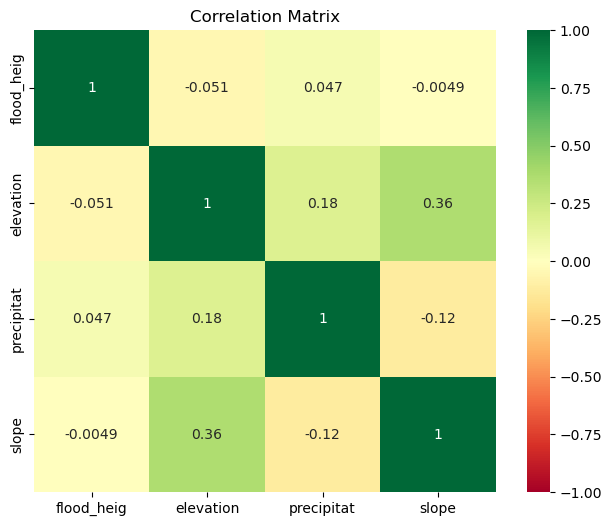

In [8]:
correlation_vars = ['flood_heig', 'elevation', 'precipitat', 'slope']
corr_matrix = data_manila_clean[correlation_vars].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0,
           square=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Slope distribution:
count    3510.000000
mean        0.458784
std         0.444507
min         0.000000
25%         0.188105
50%         0.292484
75%         0.603674
max         2.905392
Name: slope, dtype: float64

Slopes > 5°: 0
Slopes > 10°: 0
Slopes > 20°: 0

Χαμηλότερα slopes:
          lat         lon  slope
1   14.698299  121.002132    0.0
4   14.762232  121.075735    0.0
9   14.669338  121.132898    0.0
13  14.398270  121.027496    0.0
73  14.745711  121.036145    0.0

Υψηλότερα slopes:
          lat         lon     slope
76  14.648715  121.082789  2.905392
64  14.590854  121.142181  2.809722
65  14.591124  121.142460  2.809722
66  14.591020  121.142232  2.809722
97  14.590701  121.142460  2.809722


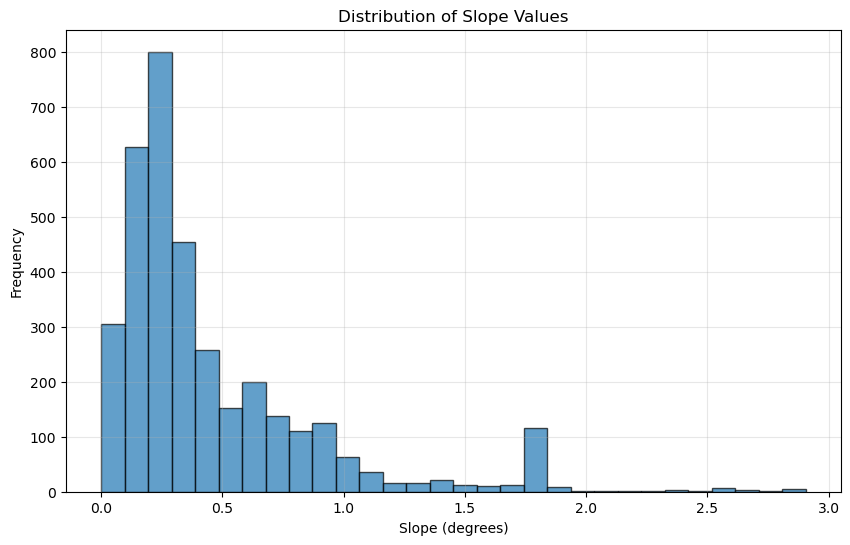

In [9]:
print("Slope distribution:")
print(data_manila_clean['slope'].describe())
print(f"\nSlopes > 5°: {(data_manila_clean['slope'] > 5).sum()}")
print(f"Slopes > 10°: {(data_manila_clean['slope'] > 10).sum()}")
print(f"Slopes > 20°: {(data_manila_clean['slope'] > 20).sum()}")


print(f"\nΧαμηλότερα slopes:")
print(data_manila_clean.nsmallest(5, 'slope')[['lat', 'lon', 'slope']])
print(f"\nΥψηλότερα slopes:")
print(data_manila_clean.nlargest(5, 'slope')[['lat', 'lon', 'slope']])


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(data_manila_clean['slope'], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Slope (degrees)')
plt.ylabel('Frequency')
plt.title('Distribution of Slope Values')
plt.grid(True, alpha=0.3)
plt.show()